## Simulated Betting Environment using the Logistic Regression Model for Predictive Analytics

1. Load the libraries needed for the development of the betting environment.

In [63]:
import joblib
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 

2. Load the Logistic Regression model using joblib library.

In [64]:
# Load the LogRg Model

model = joblib.load('logistic_regression_model.pkl')

3. Load the test data 

In [65]:
# Load the test data

X_test = joblib.load('X_test.pkl')
y_test = joblib.load('y_test.pkl')

# Load future games data 

future_games_df = pd.read_csv('datasets/FutureGames.csv')

# Ensure that X_test and y_test have the same length
assert len(X_test) == len(y_test), "X_test and y_test must have the same number of rows"

4. Define a function to simulate the betting environment

In [66]:
# Simulated betting environment
def simulate_betting_environment(X_test, y_test, model, initial_balance=1000, strategy='low'):
    balance = initial_balance
    bet_history = []
    
    for i in range(len(X_test)):
        row = pd.DataFrame([X_test.iloc[i]], columns=X_test.columns)

        # Predict the outcome
        prediction_prob = model.predict_proba(row)[0]
        predicted_class = model.predict(row)[0]
        
        # Determine bet amount
        if strategy == 'low':
            if prediction_prob[1] > 0.7:  # High confidence on home win
                bet_amount = balance * 0.05  # Bet 5% of current balance
                odds = 1 / prediction_prob[1]
            else:
                continue  # Skip this game
        elif strategy == 'high':
            if prediction_prob[1] < 0.5:  # Lower confidence, higher potential payout
                bet_amount = balance * 0.02  # Bet 2% of current balance
                odds = 1 / (1 - prediction_prob[1])
            else:
                continue  # Skip this game

        # Simulate the bet
        actual_result = y_test.iloc[i]  # 1 for home win, 0 for away win
        if predicted_class == actual_result:  # Win the bet
            payout = bet_amount * odds
            balance += payout - bet_amount
        else:  # Lose the bet
            balance -= bet_amount
        
        # Record the bet
        bet_history.append({
            'Game': i,
            'Predicted_Class': predicted_class,
            'Actual_Result': actual_result,
            'Bet_Amount': bet_amount,
            'Balance': balance,
            'Odds': odds,
            'Payout': payout if predicted_class == actual_result else 0
        })

    return pd.DataFrame(bet_history), balance

5. Run the simulation

In [67]:
# run simulation 

low_risk_history, low_risk_final_balance = simulate_betting_environment(X_test, y_test, model, strategy='low')
high_risk_history, high_risk_final_balance = simulate_betting_environment(X_test, y_test, model, strategy='high')

# convert to DataFrame for easier analysis

low_risk_df = pd.DataFrame(low_risk_history)
high_risk_df = pd.DataFrame(high_risk_history)

#prepare future games for prediction 

X_future_games = future_games_df.drop(columns=['WL_HOME', 'WL_AWAY'])
y_future_games = future_games_df['WL_HOME'].apply(lambda x:1 if x == 'W' else 0)

# run simulation on future games 

low_risk_future_history, low_risk_future_final_balance = simulate_betting_environment(X_future_games, y_future_games, model, strategy='low')
high_risk_future_history, high_risk_future_final_balance = simulate_betting_environment(X_future_games, y_future_games, model, strategy='high')



6. Analyze the profitability

In [68]:
# Analyze profitability
def analyze_strategy(df, initial_balance):
    total_bets = len(df)
    final_balance = df.iloc[-1]['Balance'] if not df.empty else initial_balance
    total_profit = final_balance - initial_balance
    win_rate = df[df['Payout'] > 0].shape[0] / total_bets if total_bets > 0 else 0
    
    return {
        'Total Bets': total_bets,
        'Final Balance': final_balance,
        'Total Profit': total_profit,
        'Win Rate': win_rate
    }

low_risk_analysis = analyze_strategy(low_risk_df, initial_balance=1000)
high_risk_analysis = analyze_strategy(high_risk_df, initial_balance=1000)

# Analysis for future games
low_risk_future_analysis = analyze_strategy(low_risk_future_history, initial_balance=1000)
high_risk_future_analysis = analyze_strategy(high_risk_future_history, initial_balance=1000)

print("Low-Risk Strategy Analysis:", low_risk_analysis)
print("High-Risk Strategy Analysis:", high_risk_analysis)
print("Low-Risk Future Games Strategy Analysis:", low_risk_future_analysis)
print("High-Risk Future Games Strategy Analysis:", high_risk_future_analysis)


Low-Risk Strategy Analysis: {'Total Bets': 1861, 'Final Balance': np.float64(4766.884165359634), 'Total Profit': np.float64(3766.8841653596337), 'Win Rate': 0.9865663621708759}
High-Risk Strategy Analysis: {'Total Bets': 1439, 'Final Balance': np.float64(1871.7975351645237), 'Total Profit': np.float64(871.7975351645237), 'Win Rate': 0.9346768589298123}
Low-Risk Future Games Strategy Analysis: {'Total Bets': 11, 'Final Balance': np.float64(903.9188518483165), 'Total Profit': np.float64(-96.08114815168346), 'Win Rate': 0.8181818181818182}
High-Risk Future Games Strategy Analysis: {'Total Bets': 9, 'Final Balance': np.float64(941.4489613619066), 'Total Profit': np.float64(-58.55103863809336), 'Win Rate': 0.6666666666666666}


7. Visualize the results 

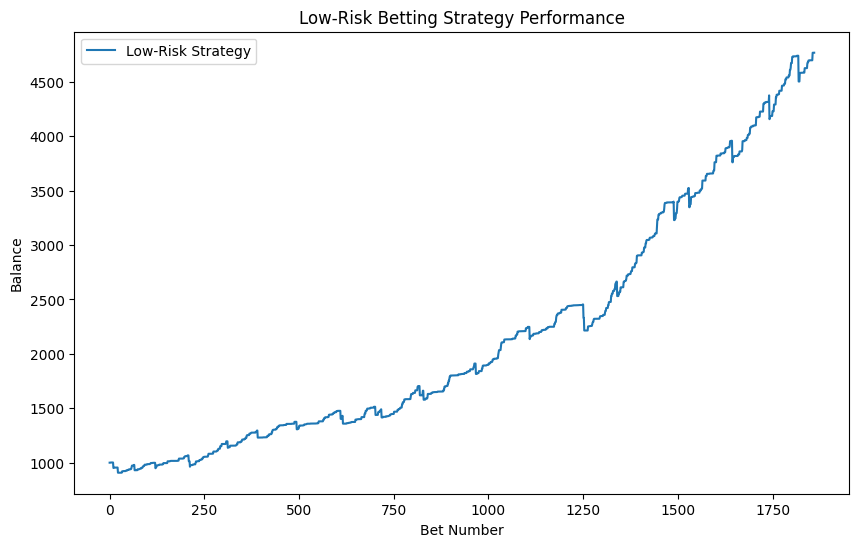

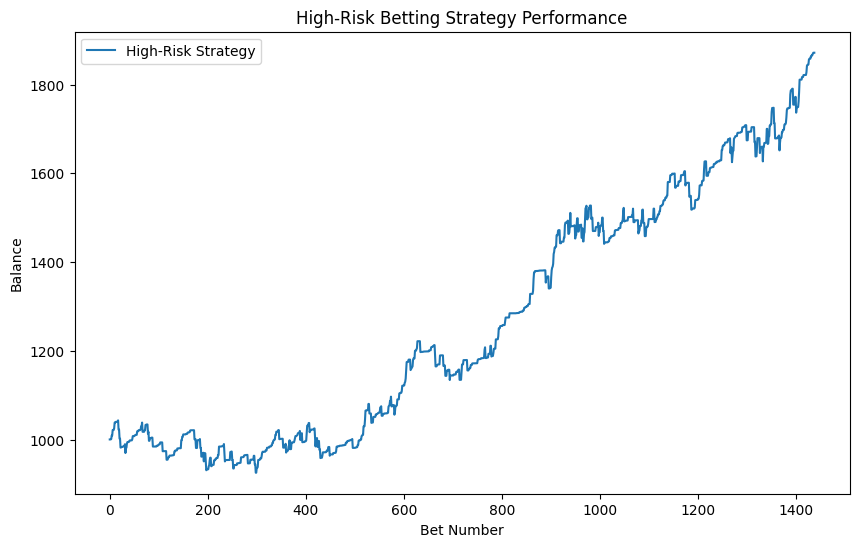

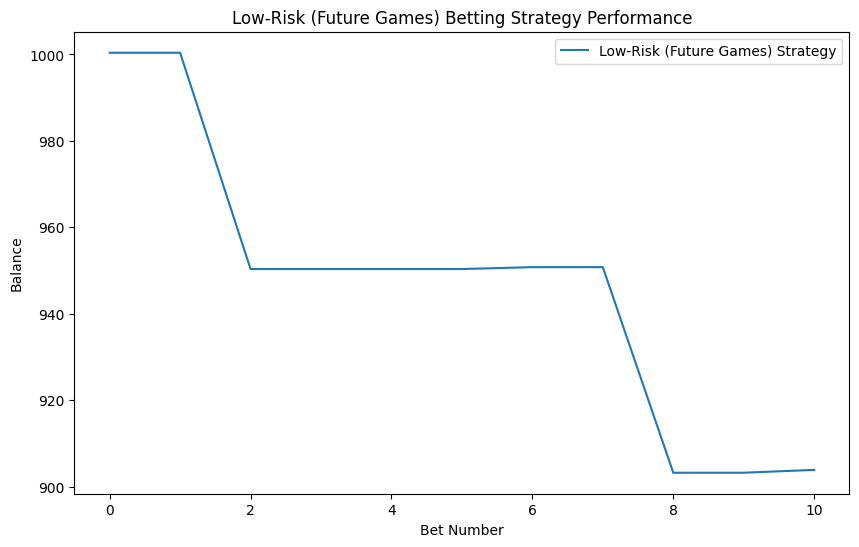

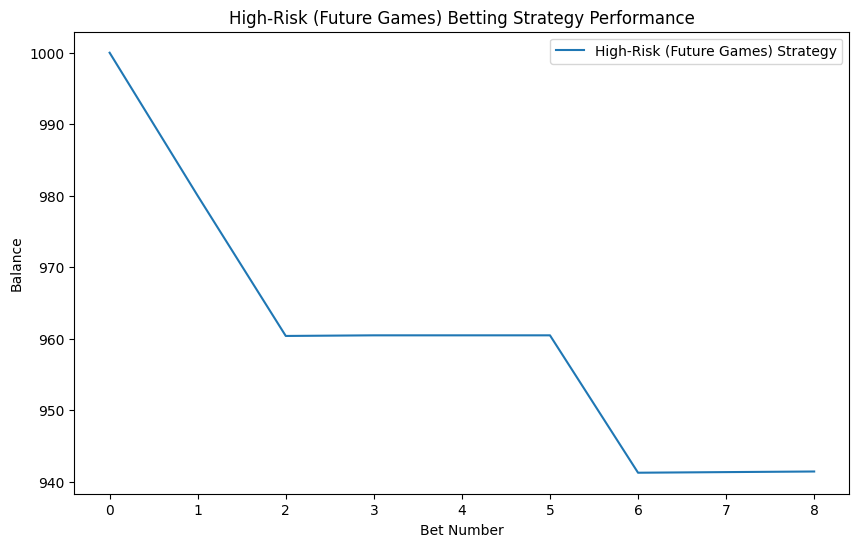

In [69]:
# Visualization
def plot_betting_strategy(df, strategy_name):
    plt.figure(figsize=(10, 6))
    plt.plot(df['Balance'], label=f'{strategy_name} Strategy')
    plt.xlabel('Bet Number')
    plt.ylabel('Balance')
    plt.title(f'{strategy_name} Betting Strategy Performance')
    plt.legend()
    plt.show()

plot_betting_strategy(low_risk_df, 'Low-Risk')
plot_betting_strategy(high_risk_df, 'High-Risk')

# Plot results for future games
plot_betting_strategy(low_risk_future_history, 'Low-Risk (Future Games)')
plot_betting_strategy(high_risk_future_history, 'High-Risk (Future Games)')